# 🧠 딥러닝 기반 이미지 분류 (불량/정상 이미지)
사전 학습된 모델과 이미지 증강을 활용한 고도화된 분류 모델 구현

## 📁 Step 1: Google Drive 연동 및 데이터 업로드

In [1]:
import gdown
import zipfile
import os

file_id = "1rIHf4kA8DDlfuD2s9zltMt6SMULBiwtJ"
gdown.download(f"https://drive.google.com/uc?id={file_id}", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1rIHf4kA8DDlfuD2s9zltMt6SMULBiwtJ
From (redirected): https://drive.google.com/uc?id=1rIHf4kA8DDlfuD2s9zltMt6SMULBiwtJ&confirm=t&uuid=832c614e-2b4b-4e9b-8c00-2ddbc0cc644b
To: /content/noodle.zip
100%|██████████| 90.2M/90.2M [00:01<00:00, 53.4MB/s]


'noodle.zip'

## 📦 Step 2: 이미지 ZIP 파일 압축 해제

In [2]:
zip_path = "/content/noodle.zip"

extract_path = "noodle"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"압축 해제 완료")

압축 해제 완료


## 🧹 Step 3: 이미지 전처리 + 증강

In [3]:

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = train_datagen.flow_from_directory(
    extract_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_gen = val_datagen.flow_from_directory(
    extract_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

class_names = list(train_gen.class_indices.keys())
print("클래스:", class_names)


Found 356 images belonging to 2 classes.
Found 88 images belonging to 2 classes.
클래스: ['false_case', 'true_case']


## 🧠 Step 4: 사전 학습된 모델 (MobileNetV2) 로드 및 미세 조정

In [4]:

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False  # 초기엔 학습 비활성화

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(train_gen.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## 🔁 Step 5: 기본 학습 (기존 가중치 고정)

In [5]:

history = model.fit(train_gen, validation_data=val_gen, epochs=5)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.4912 - loss: 1.2306 - val_accuracy: 0.5568 - val_loss: 0.7137
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 474ms/step - accuracy: 0.7106 - loss: 0.5077 - val_accuracy: 0.5909 - val_loss: 0.6422
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 472ms/step - accuracy: 0.7937 - loss: 0.4422 - val_accuracy: 0.6477 - val_loss: 0.5894
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 473ms/step - accuracy: 0.7985 - loss: 0.4497 - val_accuracy: 0.8182 - val_loss: 0.4125
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 473ms/step - accuracy: 0.8304 - loss: 0.3546 - val_accuracy: 0.8182 - val_loss: 0.4417


## 🧬 Step 6: 상위 층 미세 조정 (Fine-tuning)

In [6]:

base_model.trainable = True

# 일부 상위층만 학습 가능하도록 설정
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # 낮은 학습률
              loss='categorical_crossentropy',
              metrics=['accuracy'])

fine_tune_history = model.fit(train_gen, validation_data=val_gen, epochs=5)


Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.4837 - loss: 1.7892 - val_accuracy: 0.7727 - val_loss: 0.4971
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 481ms/step - accuracy: 0.4315 - loss: 1.7915 - val_accuracy: 0.7273 - val_loss: 0.5339
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 475ms/step - accuracy: 0.4808 - loss: 1.4567 - val_accuracy: 0.6932 - val_loss: 0.5648
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 473ms/step - accuracy: 0.5223 - loss: 1.0890 - val_accuracy: 0.6818 - val_loss: 0.5889
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 469ms/step - accuracy: 0.5996 - loss: 0.8757 - val_accuracy: 0.6932 - val_loss: 0.5870


## 📊 Step 7: 정확도 및 손실 시각화

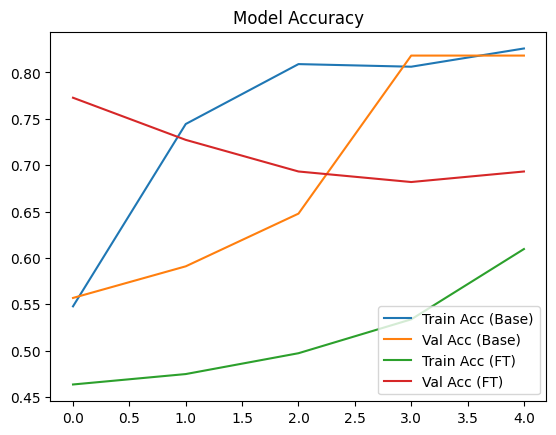

In [7]:

import matplotlib.pyplot as plt

# 기본 학습 결과
plt.plot(history.history['accuracy'], label='Train Acc (Base)')
plt.plot(history.history['val_accuracy'], label='Val Acc (Base)')

# 미세 조정 결과
plt.plot(fine_tune_history.history['accuracy'], label='Train Acc (FT)')
plt.plot(fine_tune_history.history['val_accuracy'], label='Val Acc (FT)')

plt.title("Model Accuracy")
plt.legend()
plt.show()


## 🔍 Step 8: 개별 이미지 예측 및 시각화

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


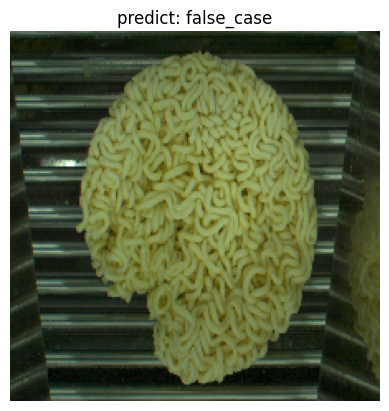

In [8]:

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# 예측을 위한 샘플 이미지 로드
sample_path = val_gen.filepaths[0]  # 검증 데이터 중 하나
img = image.load_img(sample_path, target_size=img_size)
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# 예측 수행
pred = model.predict(img_array)
pred_class = class_names[np.argmax(pred)]

# 시각화
plt.imshow(img)
plt.title(f"predict: {pred_class}")
plt.axis('off')
plt.show()


## 📉 Step 9: Confusion Matrix 및 Classification Report

3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


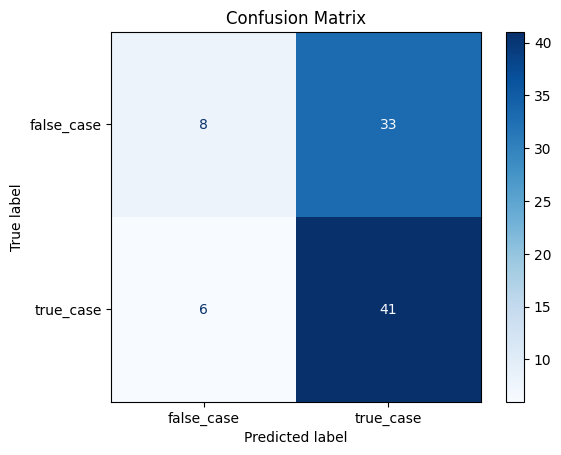

Classification Report:
              precision    recall  f1-score   support

  false_case       0.57      0.20      0.29        41
   true_case       0.55      0.87      0.68        47

    accuracy                           0.56        88
   macro avg       0.56      0.53      0.48        88
weighted avg       0.56      0.56      0.50        88



In [9]:

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# 전체 검증 데이터에 대한 예측 수행
val_gen.reset()
predictions = model.predict(val_gen, steps=val_gen.samples // val_gen.batch_size + 1)
y_pred = np.argmax(predictions, axis=1)
y_true = val_gen.classes

# 혼동 행렬 출력
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# 분류 리포트 출력
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))
